In [8]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [53]:
data = np.load("/data/Pre_training/drug_feature/Sorafenib/breast_Sorafenib_feature.npy")

In [54]:
data.shape

(14, 855)

In [5]:
!pip install pandas mygene networkx seaborn

     |████████████████████████████████| 4.7MB 23.5MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.9MB 38.9MB/s eta 0:00:01
     |████████████████████████████████| 296kB 43.4MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/5c/f4/45/389dc711f0c5ff9adeb5245397ab18bf75182e8cff9fbfa916
Successfully built pandas


In [6]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [9]:
data_file = '/data/PTDC/'
new_network_file = '/data/'

exp_data_file = data_file + 'ExpressionSamples.tsv'

drug_cell_line_file = data_file + 'DrugResponsesAUCSamples.txt'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'SNVsSamples.tsv'
drug_target_file = data_file + 'drug_target_list.csv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [19]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0)
exp_df = exp_df.T[1:]
exp_df = exp_df[intersect]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

# def stripNumber(line):
#     m = re.match('DATA\.([0-9]+)\.?', line)
#     return int(m.group(1))

# exp_df.index = exp_df.index.map(stripNumber)
# exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

# # print len(exp_cell_line_list), len(exp_gene_list)

exp_df

Gene,RNF165,CIDEA,ZNF768,SLC9A1,PML,TAF15,GAS2L2,ANAPC11,ADAMTSL4,HERC2P9,...,INPP5F,ZNF683,MFAP1,CCT3,SHISA2,BCAT1,NCKAP1L,TBC1D4,CC2D1A,IGSF9
AB521M-T,7.510755,5.792136,6.416645,8.804952,6.499975,9.909049,6.124454,9.545889,6.411178,5.719546,...,6.424557,5.977304,8.402654,9.678139,6.081699,7.532801,6.802191,7.626186,6.590437,7.371528
AB521M-TR,8.474643,5.610313,6.339061,8.623235,6.639223,9.542741,5.944080,9.815945,6.407010,5.884231,...,6.759410,5.956003,8.185264,9.614410,6.121346,6.993279,6.438270,8.197938,6.992506,7.100672
AB521M-X1,8.705916,5.811125,6.696745,8.763671,6.428139,9.934569,6.000907,9.744461,6.678793,5.837490,...,6.472909,5.970345,8.345814,9.812360,6.634860,6.660937,5.575796,7.377456,6.947622,7.639815
AB521M-X1R1,8.794421,5.879738,6.504328,9.028497,6.651181,10.791547,5.886992,9.773348,6.414930,5.857112,...,6.660112,6.071033,8.182399,9.625384,6.787401,6.894462,5.612878,7.250368,6.888878,7.723912
AB521M-XC7,8.000047,6.139092,6.683635,8.943575,6.335583,10.395806,6.158121,10.364700,6.142418,5.902103,...,6.550244,5.863836,8.124128,10.241237,7.093820,7.395031,5.738153,7.659902,6.809409,7.322919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO179-X7,6.963911,5.897613,6.762503,8.668833,6.649753,10.777742,5.751511,9.906392,6.235442,5.695761,...,6.641137,6.009198,8.451753,11.747923,6.658897,6.630375,5.808415,6.922859,6.829676,8.965324
VHIO179-X7C,6.595537,5.979926,7.312675,8.771252,6.504972,10.738292,5.758324,9.202161,6.438547,5.892632,...,6.461688,6.077867,8.383116,11.182202,7.001184,6.225123,5.662663,6.521213,7.024869,8.456172
VHIO179-X7R,6.590126,5.825495,7.182367,8.540514,6.589025,10.668308,5.702631,9.896060,6.210595,5.831915,...,6.888825,6.014146,8.455270,11.738113,6.464748,6.473099,5.564738,6.797636,6.788477,8.732550
VHIO179-X9,6.863109,5.951204,6.854045,7.956346,6.317509,10.407167,5.733269,9.874909,6.100482,5.766392,...,6.509012,5.974134,8.081476,10.702385,6.345489,7.013725,5.950739,6.822126,6.698296,8.277780


In [11]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [17]:
intersect = intersection(exp_gene_list,mutation_gene_list)

In [18]:
maf = pd.read_csv(mutation_data_file, sep='\t', index_col=1).fillna(0)
mutation_df = maf.groupby(['ID', 'Symbol']).size().unstack().fillna(0)
mutation_df = mutation_df[intersect]
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

print(len(mutation_cell_line_list), len(mutation_gene_list))

mutation_df

170 5774


Symbol,RNF165,CIDEA,ZNF768,SLC9A1,PML,TAF15,GAS2L2,ANAPC11,ADAMTSL4,HERC2P9,...,INPP5F,ZNF683,MFAP1,CCT3,SHISA2,BCAT1,NCKAP1L,TBC1D4,CC2D1A,IGSF9
ID,,,,,,,,,,,,,,,,,,,,,
AB521-T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB521M-T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB521M-X1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB521M-X1C7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB521M-X1R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO179-X7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VHIO179-X9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VHIO179-XC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
drugs = pd.read_csv(drug_cell_line_file,sep='\t',index_col=0)
drugs_cell_line_list = list(drugs.index.unique())
drug_list = drugs["Drug"].tolist()
# print len(drugs_cell_line_list)
drugs

#cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == 1026]
#cell_line_drug_matrix.loc[[924100,910924],'LN_IC50'].values

#cell_line_drug_matrix.loc[ [909758, 924247, 924107],'DRUG_ID' ]

,Model,Drug,AUC,iC50,D1_CONC,D5_CONC,perc.iC50,cluster.superv
ID,,,,,,,,
HCI001-X4C,HCI001,17-AAG,0.275699,3.669921e+04,1.000000,0.003906,289.543267,2
HCI001-X4C,HCI001,681640,0.095479,3.005775e+02,2.000000,0.007812,190.394917,2
HCI001-X4C,HCI001,ABT-263,0.461477,1.492844e-01,2.000000,0.007812,53.201694,5
HCI001-X4C,HCI001,AMG-706,0.083549,2.688117e+43,2.000000,0.007812,1890.868801,1
HCI001-X4C,HCI001,AZ628,0.269396,1.822698e+01,1.637784,0.370028,261.985001,2
...,...,...,...,...,...,...,...,...
VHIO244-X2C,VHIO244,Vorinostat,0.518689,6.062272e-01,10.000000,0.039062,49.450029,5
VHIO244-X2C,VHIO244,XAV 939,0.060293,1.820637e+05,5.581430,1.175631,767.205953,1
VHIO244-X2C,VHIO244,YK 4-279,0.161984,1.492000e+01,7.701322,2.337740,155.469442,2


In [22]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []

for line in file_handle:
    
    new_line = line.rstrip().split(',')
    drug = new_line[0]
    target_list=new_line[1:]
    target_list_str = ""
    for i in range(0,len(target_list)):
        if i == len(target_list) - 1:
            target_list_str += target_list[i].replace('"','')
        else:
            target_list_str += target_list[i].replace('"','') + ","
    drug = drug.strip()
    
    drug_target_map[drug] = []
    
    if ',' not in target_list_str:
        drug_target_map[drug].append(target_list_str.strip())
        drug_target_list.append(target_list_str.strip())
    else:
        target_list = target_list_str.split(',')
        for target in target_list:
            drug_target_map[drug].append(target.strip())
            drug_target_list.append(target.strip())

# print len(drug_target_list)
# print drug_target_map

In [37]:
drug_intersect = intersection(list(drug_target_map.keys()),drug_list)

In [36]:
base_dir = "/data/Pre_training/drug_feature/
drugs_files = os.listdir("../data/Pre_training/drug_feature/")
for i in drugs_files:
    if i not in drug_in

['PTDC',
 'PathwayCommons9.All.hgnc.sif',
 'InBioMap_Symbol.sif',
 'PathwayCommons_Symbol.sif',
 'HUGO_protein-coding_gene.tsv',
 'sample_drug_feature',
 'allComplexes.txt',
 'Sorafenib',
 'Sorafenib_tissue_map.pkl',
 'Pre_training']

In [39]:
drug_target_map_copy = {key: value for key, value in drug_target_map.items() if key in drug_intersect}
drug_target_map = drug_target_map_copy
drug_target_list_copy = intersection(drug_intersect,drug_target_list)
new_drug_target_list = []
for k,v in drug_target_map.items():
    new_drug_target_list.extend(drug_target_map[k])
drug_target_list = new_drug_target_list

In [41]:
drug_target_map

{'Erlotinib': ['EGFR'],
 'Paclitaxel': ['Microtubules'],
 'AZ628': ['BRAF'],
 'Sorafenib': ['PDGFRA', 'PDGFRB', 'KDR', 'KIT', 'FLT3'],
 'BI-2536': ['PLK1', 'PLK2', 'PLK3'],
 'BMS-536924': ['IGF1R'],
 'Bortezomib': ['Proteasome'],
 'Lapatinib': ['ERBB2', 'EGFR'],
 'GSK269962A': ['ROCK1', 'ROCK2'],
 'Bicalutamide': ['ANDR (androgen receptor)'],
 'CHIR-99021': ['GSK3B'],
 'AZD6482': ['PI3Kbeta'],
 'PF-562271': ['FAK'],
 'JQ1': ['BRD2', 'BRD3', 'BRD4'],
 'AKT inhibitor VIII': ['AKT1', 'AKT2', 'AKT3'],
 'Embelin': ['XIAP'],
 'PAC-1': ['CASP3 agonist'],
 '5-Fluorouracil': ['DNA antimetabolite'],
 'Obatoclax Mesylate': ['BCL2', 'BCL2L1', 'MCL1'],
 'BMS-754807': ['IGF1R'],
 'OSI-906': ['IGF1R'],
 'BMS-345541': ['IKBKB'],
 'BMS-708163': ['g-secretase'],
 'LY317615': ['PRKCB (PKCbeta)'],
 'AICAR': ['AAPK1 (AMPK) agonist'],
 'Camptothecin': ['TOP1'],
 'Vinblastine': ['Microtubules'],
 'Cisplatin': ['DNA crosslinker'],
 'Docetaxel': ['Microtubules'],
 'Gefitinib': ['EGFR'],
 'ABT-263': ['BCL2', 'B

In [134]:
drugs_legend = pd.read_csv('/data/PTDC/Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index

In [141]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map = load_network(network_list, valid_gene_list)

In [142]:
gene_name_df = pd.read_table('/data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (31,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [143]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [144]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

querying 1-43...done.
Finished.
1 input query terms found dup hits:
	[('P01871', 2)]
25 input query terms found no hit:
	['Q13745', 'Q1EHW4', 'Q16198', 'Q8IUB6', 'Q13791', 'O15320', 'Q3V639', 'P48830', 'Q9NY11', 'Q59EJ3',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [145]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

In [146]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])

TELO2 not in itself? nan
SIDT2 not in itself? nan
PTPRU not in itself? nan


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

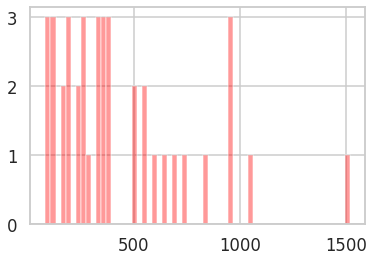

In [149]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    
    drug_neighbor_map[drug] = set()
    
    for gene in target_list:
        
        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            continue
    
        if gene in gene_exp_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]
            
        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
    
    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append( len(drug_neighbor_map[drug]) )

sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

In [232]:
cell_line_list = list(set(exp_cell_line_list)&set(drugs_cell_line_list))
print(len(cell_line_list))

3


In [204]:
intersection(cell_line_list,drugs_cell_line_list)

[]

In [167]:
cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)
## print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))

# print 'How many tissues', len(tissue_map)
# print 'Large tissues', large_tissue_number

NameError: name 'cell_line_detail_file' is not defined

In [235]:
tissue_map ={'Breast':cell_line_list}

In [236]:
tissue_map

{'Breast': ['STG282-X1C', 'STG282-X1CR', 'HCI009-X4C']}

In [225]:
drugs["LN_IC50"] = np.log(drugs["iC50"])

In [226]:
drugs

,Model,Drug,AUC,iC50,D1_CONC,D5_CONC,perc.iC50,cluster.superv,LN_IC50
ID,,,,,,,,,
HCI001-X4C,HCI001,17-AAG,0.275699,3.669921e+04,1.000000,0.003906,289.543267,2,10.510511
HCI001-X4C,HCI001,681640,0.095479,3.005775e+02,2.000000,0.007812,190.394917,2,5.705706
HCI001-X4C,HCI001,ABT-263,0.461477,1.492844e-01,2.000000,0.007812,53.201694,5,-1.901902
HCI001-X4C,HCI001,AMG-706,0.083549,2.688117e+43,2.000000,0.007812,1890.868801,1,100.000000
HCI001-X4C,HCI001,AZ628,0.269396,1.822698e+01,1.637784,0.370028,261.985001,2,2.902903
...,...,...,...,...,...,...,...,...,...
VHIO244-X2C,VHIO244,Vorinostat,0.518689,6.062272e-01,10.000000,0.039062,49.450029,5,-0.500501
VHIO244-X2C,VHIO244,XAV 939,0.060293,1.820637e+05,5.581430,1.175631,767.205953,1,12.112112
VHIO244-X2C,VHIO244,YK 4-279,0.161984,1.492000e+01,7.701322,2.337740,155.469442,2,2.702703


In [243]:
new_data_file = ''

# print mutation_df.shape, exp_df.shape

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

# print np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5)#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

#cell_line2id = dict(zip(cell_line_list, range(len(cell_line_list))))

rename_selected_drug_list = []

for drug in selected_drug_list:
    
#     if drug != 'Nutlin-3a (-)':
#         continue
    
    if drug not in drug2id_mapping:
        # print 'drug name wrong', drug
        break
    
    cell_line_drug_matrix = drugs.loc[drugs['Drug'] == drug]
    
    ## print cell_line_drug_matrix
    
    feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
    feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
    
    if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
        continue
    
    feature_description = []
    
    drug_tissue_map = {}
    
    drug = drug.replace(' ','_')
    
    rename_selected_drug_list.append(drug)
    
    # print drug
    if drug == 'Nutlin-3a_(-)':
        drug = 'Nutlin-3a'
    
    drug_folder = 'drug_feature/' + drug + '/'
    if not os.path.exists(drug_folder):
        os.makedirs(drug_folder)
        
    # print 'Generate features', drug
    
    for tissue, tissue_cell_line_list in tissue_map.items():
        
        drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
        drug_specific_cell_line = list(drug_specific_cell_line)
        drug_tissue_map[tissue] = drug_specific_cell_line
        
        feature_list = []
        
        if len(feature_exp_gene_list) != 0:
            feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
            for gene in feature_exp_gene_list:
                feature_description.append(gene+'_expression')
        
        if len(feature_mut_gene_list) != 0:
            print(mutation_df.loc[ drug_specific_cell_line,featu].values)
            #feature_list.append( mutation_df.loc[ drug_specific_cell_line,feature_exp_gene_list].values )
            feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
            for gene in feature_mut_gene_list:
                feature_description.append(gene+'_mutation')
            
        feature = np.concatenate(feature_list, axis=1)
        
        label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values
        
        #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values
    
        # print feature.shape, label.shape
     
        np.save(drug_folder + 'PDTC' + '_' + drug + '_feature.npy', feature )
        np.save(drug_folder + 'PDTC' + '_' + drug + '_label.npy', label)
        #np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        
    #file_handle = open(new_data_file + drug+'_tissue_cell_line_list.pkl',"wb")
    #pickle.dump(drug_tissue_map,file_handle)
    #file_handle.close()
    
#file_handle = open('rename_selected_drug_list', 'w')
#for drug in rename_selected_drug_list:
    #file_handle.writelines(drug+ '\n')
#file_handle.close()


KeyError: "None of [Index(['STG282-X1C', 'STG282-X1CR'], dtype='object', name='ID')] are in the [index]"

In [234]:
len(drug_specific_cell_line)

0

In [31]:
len(drug_tissue_map['breast'])

46

In [35]:
import pickle

In [37]:
cell_line_loc = '/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/cell_line_lists/'

In [38]:
with open(cell_line_loc + 'KU-55933_tissue_cell_line_list.pkl', 'rb') as f: 
    tmap= pickle.load(f)

In [48]:
tmap.keys()

['large_intestine',
 'vulva',
 'pleura',
 'endometrium',
 'lung',
 'skin',
 'autonomic_ganglia',
 'kidney',
 'thyroid',
 'cervix',
 'testis',
 'central_nervous_system',
 'oesophagus',
 'NS',
 'upper_aerodigestive_tract',
 'biliary_tract',
 'stomach',
 'soft_tissue',
 'urinary_tract',
 'liver',
 'prostate',
 'pancreas',
 'placenta',
 'adrenal_gland',
 'salivary_gland',
 'small_intestine',
 'haematopoietic_and_lymphoid_tissue',
 'ovary',
 'bone',
 'breast']

In [49]:
len(tmap['lung'])

137

In [50]:
f = np.load('/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/drug_feature/KU-55933/lung_KU-55933_feature.npy')

In [51]:
f.shape

(137, 1502)